In [26]:
from PyPESTO.COMP.CPE import CopolymerEquations, cpe_model, create_wrapper, cpe_model_
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Define the model parameters
r1_true = 3.0
r2_true = 0.5
b1_true = 0.0
g1_true = 0.0
b2_true = 0.0
g2_true = 0.0

# Initial fit guesses
r1_guess = r1_true 
r2_guess = r2_true

params_true = {
    'r1': r1_true,
    'r2': r2_true,
    'b1': b1_true,
    'g1': g1_true,
    'b2': b2_true,
    'g2': g2_true,
}

params_fit_guess = {
    'r1': r1_guess,
    'r2': r2_guess,
}

params_fit_bounds = {
    'r1': (1e-3, 1e3),
    'r2': (1e-3, 1e3),
}

# Assert that params_fit is within params_fit_bounds
if not all([params_fit_guess[key] >= params_fit_bounds[key][0] and params_fit_guess[key] <= params_fit_bounds[key][1] for key in params_fit_guess]):
    raise ValueError('Initial guess is not within bounds')

params_fixed = {key:val for key, val in params_true.items() if key not in params_fit_guess}


print('True param values:', params_true)
print('Fixed params:', params_fixed)
print('Fit params (bounds):', params_fit_bounds)
print('Fit params (initial guess):', params_fit_guess)

True param values: {'r1': 3.0, 'r2': 0.5, 'b1': 0.0, 'g1': 0.0, 'b2': 0.0, 'g2': 0.0}
Fixed params: {'b1': 0.0, 'g1': 0.0, 'b2': 0.0, 'g2': 0.0}
Fit params (bounds): {'r1': (0.001, 1000.0), 'r2': (0.001, 1000.0)}
Fit params (initial guess): {'r1': 3.0, 'r2': 0.5}


In [10]:
X_eval = np.linspace(0.02, 0.95, 10)
data = cpe_model(X_eval, **params_true)

rng = np.random.default_rng()
y_noise = 0.00 * rng.normal(size=data.size)
y_exp = data + y_noise

Text(0, 0.5, 'B conversion')

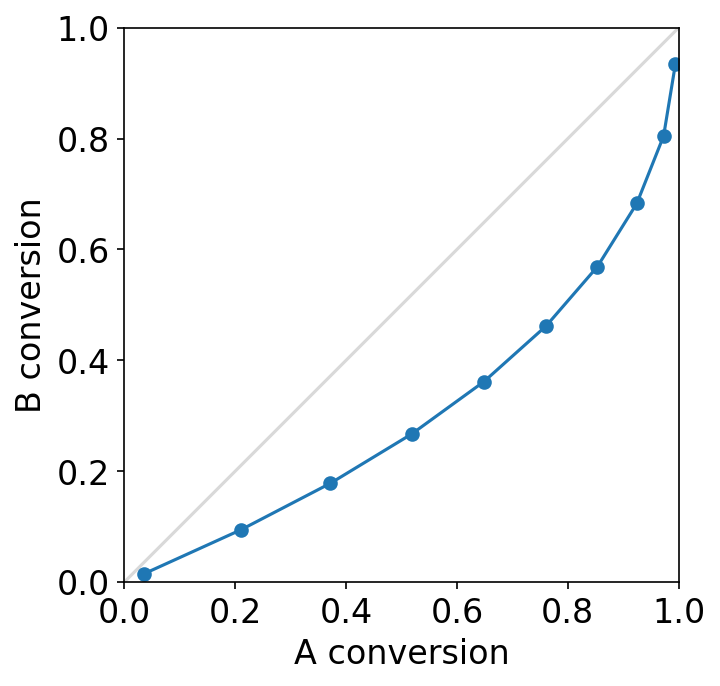

In [28]:


data_exp = y_exp.reshape(2, -1)
plt.figure(dpi=150)
# plt.plot(X_eval, data[0], 'o-')
# plt.plot(X_eval, 2*X_eval - data[1], 'o-')
plt.plot(data_exp[0], data_exp[1], 'o-')
plt.plot([0, 1], [0, 1], 'k-', alpha=0.15)
plt.xlim([0, 1])
plt.ylim([0, 1])

# Make the plot square
plt.gca().set_aspect('equal', adjustable='box')

# Increase the font size
plt.rcParams.update({'font.size': 16})

plt.xlabel('A conversion')
plt.ylabel('B conversion')
# plt.legend(['A', 'B'])

In [29]:

from scipy.optimize import curve_fit
fit_func = create_wrapper(cpe_model, params_fixed, params_fit_guess)
# params, cov = curve_fit(fit_func, X_eval, y_exp, method='trf', loss='soft_l1', p0=list(params_fit_guess.values()), xtol=1e-15, ftol=1e-15)#, bounds=params_fit_bounds.values(), verbose=2, full_output=True, xtol=1e-15, ftol=1e-15, gtol=1e-15)

params, cov, infodict, errmsg, ier = curve_fit(fit_func, X_eval, y_exp, p0=list(params_fit_guess.values()), bounds=tuple(zip(*params_fit_bounds.values())), verbose=2, full_output=True, xtol=1e-15)


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.


In [30]:
def cost_function(params):
    return np.sum((fit_func(X_eval, *params) - y_exp)**2)

cost_function(list(params_fit_guess.values()))

np.float64(0.0)

In [33]:
# from scipy.optimize import differential_evolution

# result = differential_evolution(cost_function, list(params_fit_bounds.values()))

KeyboardInterrupt: 

In [37]:
import pymc as pm

X_eval = np.linspace(0.1, 0.7, 7)
with pm.Model() as model:
    
    # Priors for unknown parameters
    r1 = pm.Uniform("r1", lower=1e-3, upper=1e3)
    r2 = pm.Uniform("r2", lower=1e-3, upper=1e3)

    # Likelihood (observed data)
    # params_dict = {
    #     'r1': r1,
    #     'r2': r2,
    #     'b1': 0.0,
    #     'g1': 0.0,
    #     'b2': 0.0,
    #     'g2': 0.0,
    # }
    params_tuple = (r1, r2, 0.0, 0.0, 0.0, 0.0)
    # mu = cpe_model(X_eval, **params_dict)
    # sigma = 0.1  # Assume known noise level
    
    sim = pm.Simulator('sim', cpe_model_, params=params_tuple, observed=y_exp)
    trace = pm.sample_smc()
    # Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=y_exp)

    # Inference
    # trace = pm.sample(2000, return_inferencedata=True)

# Plot posterior distributions
pm.plot_posterior(trace)
plt.show()

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.
Apply node that caused the error: Simulator_sim_rv{"(),(),(),(),(),()->()"}(simulator_rng, [20], Composite{((1000.0 * sigmoid(i0)) + (0.001 * (1.0 - sigmoid(i0))))}.0, Composite{((1000.0 * sigmoid(i0)) + (0.001 * (1.0 - sigmoid(i0))))}.0, [0.], [0.], [0.], [0.])
Toposort index: 8
Inputs types: [RandomGeneratorType, TensorType(int64, shape=(1,)), TensorType(float64, shape=(1,)), TensorType(float64, shape=(1,)), TensorType(float32, shape=(1,)), TensorType(float32, shape=(1,)), TensorType(float32, shape=(1,)), TensorType(float32, shape=(1,))]
Inputs shapes: ['No shapes', (1,), (1,), (1,), (1,), (1,), (1,), (1,)]
Inputs strides: ['No strides', (8,), (8,), (8,), (4,), (4,), (4,), (4,)]
Inputs values: [Generator(PCG64) at 0xFFFF765AD9A0, array([20]), array([531.06031727]), array([661.32401729]), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32)]
Outputs clients: [[output[1](Simulator_sim_rv{"(),(),(),(),(),()->()"}.0)], [Composite{sqr((i0 - i1))}(sim{[0.0353530 ... .93526827]}, Simulator_sim_rv{"(),(),(),(),(),()->()"}.out)]]

Backtrace when the node is created (use PyTensor flag traceback__limit=N to make it longer):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/concurrent/futures/process.py", line 246, in _process_worker
    r = call_item.fn(*call_item.args, **call_item.kwargs)
  File "/usr/local/lib/python3.10/dist-packages/pymc/smc/sampling.py", line 340, in _sample_smc_int
    smc._initialize_kernel()
  File "/usr/local/lib/python3.10/dist-packages/pymc/smc/kernels.py", line 245, in _initialize_kernel
    self.likelihood_logp_func = _logp_forw(
  File "/usr/local/lib/python3.10/dist-packages/pymc/smc/kernels.py", line 633, in _logp_forw
    out_list, inarray0 = join_nonshared_inputs(
  File "/usr/local/lib/python3.10/dist-packages/pymc/pytensorf.py", line 626, in join_nonshared_inputs
    new_outputs = [
  File "/usr/local/lib/python3.10/dist-packages/pymc/pytensorf.py", line 627, in <listcomp>
    pytensor.clone_replace(output, replace, rebuild_strict=False) for output in outputs

HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [36]:
pm.plot_posterior(trace)
plt.show()

NameError: name 'trace' is not defined

In [18]:
X_eval

TypeError: float() argument must be a string or a real number, not 'TensorVariable'

[0.03535309 0.21038697 0.37188057 0.51847768 0.64866415 0.76083044
 0.85331516 0.92446817 0.97279083 0.99419518 0.0148823  0.09431545
 0.17826203 0.26717411 0.36155639 0.46194541 0.56889495 0.68295505
 0.80462528 0.93526827]
[[0.03535309 0.21038697 0.37188057 0.51847768 0.64866415 0.76083044
  0.85331516 0.92446817 0.97279083 0.99419518]
 [0.0148823  0.09431545 0.17826203 0.26717411 0.36155639 0.46194541
  0.56889495 0.68295505 0.80462528 0.93526827]]


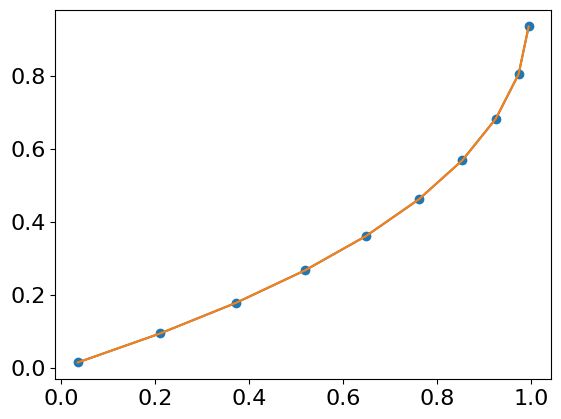

In [31]:
data = fit_func(X_eval, *params)
print(data)
data = data.reshape((2, int(len(data)/2)))
print(data)
plt.plot(data_exp[0], data_exp[1], 'o-')
plt.plot(data[0], data[1])


In [8]:
params

array([2.75, 0.75])